# Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import pickle

import warnings
warnings.filterwarnings("ignore")

# Train-Test
from sklearn.model_selection import train_test_split

# Normalization
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Load data from pickle file

In [2]:
df_train_processed = pd.read_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

In [3]:
# Split into train/cv
X_train, X_cv, y_train, y_cv = train_test_split(
    df_train_processed.drop(['RainTomorrow','RainfallTomorrow'], axis=1),
    df_train_processed['RainTomorrow'],
    test_size=0.1,
    random_state=0,   
    stratify=df_train_processed['RainTomorrow'])

## Feature selection: PCA

In [4]:
explained_variance = .95
pca = PCA(n_components=explained_variance).fit(X_train)

X_train_pca = pca.transform(X_train)
X_cv_pca = pca.transform(X_cv)

print("Number of components required to explain "+str(explained_variance)+"% of the variance = "+str(X_train_pca.shape[1]))

Number of components required to explain 0.95% of the variance = 16


## Feature selection: RFE (with simple Logistic Regression)

In [5]:
logisticRegr = LogisticRegression(class_weight='balanced')

rfe = RFE(estimator=logisticRegr, step=1, verbose=0, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train.values.ravel())

total_cols = np.array(X_train.columns.values.tolist())
selected_cols = total_cols[rfe.support_].tolist()
X_train_rfe = X_train[selected_cols]
X_cv_rfe =  X_cv[selected_cols]
print("Columns selected: "+str(selected_cols))

Columns selected: ['Rainfall', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm', 'RainToday', 'LocationType_0', 'LocationType_1', 'LocationType_2', 'LocationType_3', 'LocationType_4', 'PressureMean', 'TempMaxDiff', 'imputed_mean', 'WindDir9am_sin', 'WindDir3pm_sin']


In [6]:
# Save data
open_file = open('./data/clf_pca.pkl', "wb")
pickle.dump(pca, open_file)
open_file.close()

open_file = open('./data/clf_rfe_cols.pkl', "wb")
pickle.dump(selected_cols, open_file)
open_file.close()

# Train Models

In [7]:
def testModel(clf_,grid_values_,X_train_,y_train_,X_cv_,y_cv_,scoring_='f1',verbose_=0):
    # model.get_params() # Return selected params
    # cv=None -> None, to use the default 5-fold cross validation (K-Fold, k=5)
    model_ = GridSearchCV(clf_, param_grid = grid_values_, cv=None, scoring=scoring_,verbose=verbose_)
    model_.fit(X_train_, y_train_)

    y_pred = model_.predict(X_cv_)
    metrics_={    
        "accuracy":         metrics.accuracy_score(y_cv_, y_pred),
        "precision":        metrics.precision_score(y_cv_, y_pred),
        "recall":           metrics.recall_score(y_cv_, y_pred),
        "f1_score":         metrics.f1_score(y_cv_, y_pred),
        "confusion_matrix": metrics.confusion_matrix(y_cv_, y_pred)
    }
    return model_, metrics_

def train_models(X_train_, y_train_, X_cv_, y_cv_, features_selection='',class_weight='balanced',add_dummy=False):
    model_list=[]

    # Dummy Classifier
    if add_dummy and class_weight==None:
        clf = DummyClassifier(strategy= 'most_frequent')
        grid_values={}
        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'DummyClassifier',
            'model': model,
            'features_selection': features_selection,
            'class_weight': class_weight,
            'metrics': model_metrics
            }
        )

    # LogisticRegression
    clf = LogisticRegression(class_weight=class_weight)
    grid_values = {
        'penalty': ['l2',None],
        'C': [0.01,.1,1,10],
        }

    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'LogisticRegression',
        'model': model,
        'features_selection': features_selection,
        'class_weight': class_weight,
        'metrics': model_metrics  
        }
    )

    # SGDClassifier
    # Linear classifiers (SVM, logistic regression, etc.) with SGD training. 
    # For best results using the default learning rate schedule, the data should have zero mean and unit variance.
    loss_list = [           # List of models
        'hinge',            # SVM
        'log',              # Logistic Regression
        'squared_hinge',    # Like hinge but quadratically penalized
    ]

    for loss in loss_list:
        grid_values = {
            'l1_ratio': [0,0.25,0.5,0.75,1], # (0 <= l1_ratio <= 1): l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1
            'alpha': [0.01,.1,1,10], # The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
            'eta0': [0.001,0.1,1] # Initial learning rate
            }

        clf = SGDClassifier(class_weight=class_weight, verbose=0, max_iter=1000, tol=1e-3, penalty='elasticnet',
                            learning_rate='optimal', early_stopping=True, validation_fraction=0.1, 
                            n_iter_no_change=5, loss=loss)

        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'SGDClassifier_'+str(loss),
            'model': model,
            'features_selection': features_selection,
            'class_weight': class_weight,
            'metrics': model_metrics    
            }
        )

    # DecisionTreeClassifier
    clf = DecisionTreeClassifier(class_weight=class_weight)
    grid_values = {}
    X_train_,y_train_,X_cv_,y_cv_ = X_train_pca, y_train, X_cv_pca, y_cv
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'DecisionTreeClassifier',
        'model': model,
        'features_selection': features_selection,
        'class_weight': class_weight,
        'metrics': model_metrics    
        }
    )

    return model_list

In [8]:
model_list_pca_unbalanced = train_models(X_train_pca, y_train, X_cv_pca, y_cv, features_selection='PCA',class_weight=None,add_dummy=True)
model_list_rfe_unbalanced = train_models(X_train_rfe, y_train, X_cv_rfe, y_cv, features_selection='RFE',class_weight=None,add_dummy=True)
model_list_pca = train_models(X_train_pca, y_train, X_cv_pca, y_cv, features_selection='PCA')
model_list_rfe = train_models(X_train_rfe, y_train, X_cv_rfe, y_cv, features_selection='RFE')

model_list = model_list_pca+model_list_rfe+model_list_pca_unbalanced+model_list_rfe_unbalanced

In [10]:
models_df = None
column_names = ["name","features_selection","class_weight","accuracy","precision","recall","f1_score","confusion_matrix","model"]
models_df = pd.DataFrame(columns=column_names)
for m in model_list:
    m_append = []
    m_append.append(m["name"])
    m_append.append(m["features_selection"])
    m_append.append(m["class_weight"])
    m_append.append(m["metrics"]["accuracy"])
    m_append.append(m["metrics"]["precision"])
    m_append.append(m["metrics"]["recall"])
    m_append.append(m["metrics"]["f1_score"])
    m_append.append(m["metrics"]["confusion_matrix"])
    m_append.append(m["model"])

    m_series = pd.Series(m_append, index = models_df.columns)
    models_df = models_df.append(m_series, ignore_index=True)
models_df[['name','features_selection','class_weight','accuracy','precision','recall','f1_score',"confusion_matrix"]]

,name,features_selection,class_weight,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegression,PCA,balanced,0.761341,0.392867,0.728609,0.510482,"[[7104, 2145], [517, 1388]]"
1,SGDClassifier_hinge,PCA,balanced,0.761072,0.392107,0.724934,0.508937,"[[7108, 2141], [524, 1381]]"
2,SGDClassifier_log,PCA,balanced,0.758114,0.388967,0.729134,0.507305,"[[7067, 2182], [516, 1389]]"
3,SGDClassifier_squared_hinge,PCA,balanced,0.749507,0.380543,0.743307,0.503377,"[[6944, 2305], [489, 1416]]"
4,DecisionTreeClassifier,PCA,balanced,0.799892,0.411190,0.397375,0.404164,"[[8165, 1084], [1148, 757]]"
5,LogisticRegression,RFE,balanced,0.764479,0.396680,0.727559,0.513428,"[[7141, 2108], [519, 1386]]"
6,SGDClassifier_hinge,RFE,balanced,0.767886,0.399824,0.716535,0.513254,"[[7200, 2049], [540, 1365]]"
7,SGDClassifier_log,RFE,balanced,0.764210,0.395503,0.720210,0.510607,"[[7152, 2097], [533, 1372]]"
8,SGDClassifier_squared_hinge,RFE,balanced,0.807154,0.446661,0.540682,0.489195,"[[7973, 1276], [875, 1030]]"
9,DecisionTreeClassifier,RFE,balanced,0.802582,0.418719,0.401575,0.409968,"[[8187, 1062], [1140, 765]]"


In [2]:
# Save
open_file = open('./data/clf_list.pkl', "wb")
pickle.dump(model_list, open_file)
open_file.close()

models_df.to_pickle('./data/clf_df.pkl')

# # Load
# open_file = open('./data/clf_list.pkl', "rb")
# model_list = pickle.load(open_file)
# open_file.close()

# models_df = pd.read_pickle('./data/clf_df.pkl')

In [3]:
metrics_list=["accuracy","precision","recall","f1_score"]
for met in metrics_list:
    idx = models_df[met].argmax()
    name = models_df.iloc[idx]["name"] 
    features_selection = models_df.iloc[idx]["features_selection"] 
    class_weight = models_df.iloc[idx]["class_weight"]
    value = models_df.iloc[idx][met]
    print("best "+str(met)+" = "+"{:10.2f}".format(value)+":\t"+str(name)+" (features="+str(features_selection)+", class_weight="+str(class_weight)+")")

best accuracy =       0.86:	SGDClassifier_log (features=PCA, class_weight=None)
best precision =       0.82:	SGDClassifier_hinge (features=RFE, class_weight=None)
best recall =       0.74:	SGDClassifier_squared_hinge (features=PCA, class_weight=balanced)
best f1_score =       0.51:	LogisticRegression (features=RFE, class_weight=balanced)


# Final Test

In [13]:
# # Load Data
df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_pca.pkl', "rb")
pca = pickle.load(open_file)
open_file.close()
open_file = open('./data/clf_rfe_cols.pkl', "rb")
selected_cols = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_list.pkl', "rb")
model_list = pickle.load(open_file)
open_file.close()

models_df = pd.read_pickle('./data/clf_df.pkl')

In [14]:
# # Remove NaN (no needed)
df_test_processed = df_test_processed[df_test_processed['RainTomorrow'].notna()]

# # Split X, y
X_test = df_test_processed.drop(['RainTomorrow','RainfallTomorrow'],axis=1)
y_test = df_test_processed.RainTomorrow

# # Select and print best_model
print('Best model: '+str(models_df.iloc[models_df['f1_score'].argmax()]['name'])+ " (" \
    + str(models_df.iloc[models_df['f1_score'].argmax()]['features_selection'])+")")
best_model = models_df.iloc[models_df['f1_score'].argmax()]['model']

Best model: LogisticRegression (RFE)


In [15]:
# Transform PCA
# X_test_trf = pca.transform(X_test)

# Transform RFE
X_test_trf = X_test[selected_cols]

# Predict
y_pred = best_model.predict(X_test_trf)

# Get metrics
test_metrics={    
    "accuracy":         metrics.accuracy_score(y_test, y_pred),
    "precision":        metrics.precision_score(y_test, y_pred),
    "recall":           metrics.recall_score(y_test, y_pred),
    "f1_score":         metrics.f1_score(y_test, y_pred),
    "confusion_matrix": metrics.confusion_matrix(y_test, y_pred)
}

test_metrics

{'accuracy': 0.7613059250302298,
 'precision': 0.3889612080187451,
 'recall': 0.7087286527514232,
 'f1_score': 0.502269288956127,
 'confusion_matrix': array([[7950, 2347],
        [ 614, 1494]], dtype=int64)}

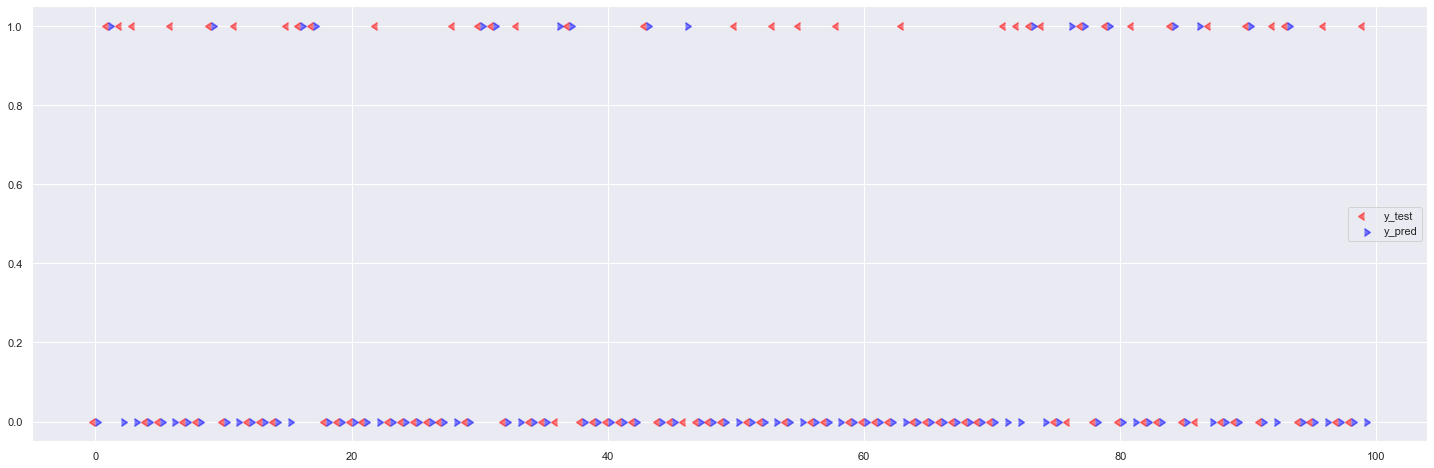

In [16]:
TRUNC = 100 #-1: do not trunc
x = np.linspace(0,y_test.shape[0]-1,y_test.shape[0])
plt.figure(figsize=(25,8))
plt.scatter(x[0:TRUNC],y_pred[0:TRUNC],color='red',alpha=.5, marker=8,s=60, label="y_test")
plt.scatter(x[0:TRUNC],y_test[0:TRUNC],color='blue',alpha=.5, marker=9,s=60, label="y_pred")
plt.legend()